In [1]:
import numpy as np
import torch
import cv2
import seaborn as sns

from models import model_dict
from helper.util_gen import get_sample_q

# Get model and replay buffer

In [2]:
!ls save/student_model/resnet28x10_T:resnet32x4_S:resnet8x4_cifar10_lr_1e-05_decay_0.0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1.0_trial_1_cls_mode_cls_k_10

img_sample_eval       img_samples  res_epoch_72.pts  sample_10_perclass.png
img_sample_eval_grid  log.txt	   res_epoch_74.pts


In [3]:
!nvidia-smi

Mon Aug 23 11:09:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:05:00.0 Off |                  N/A |
| 72%   65C    P2   344W / 350W |  22427MiB / 24268MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:09:00.0 Off |                  N/A |
| 76%   

| Wide-Resnet 28x10


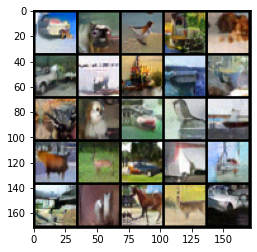

In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = "cuda:2"
model = model_dict['resnet28x10'](depth=28, widen_factor=10, num_classes=10, norm='none')
model = model_dict['Gen'](model, n_cls=10)
model = model.to(device)
save_path = '/data/lijingru/EBKD/save/student_model/resnet28x10_T:resnet32x4_S:resnet8x4_cifar10_lr_1e-05_decay_0.0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1.0_trial_1_cls_mode_cls_k_10/'
ckpt_dict = torch.load(save_path + 'res_epoch_74.pts', map_location=device)
model.load_state_dict(ckpt_dict["model_state_dict"])
replay_buffer = ckpt_dict["replay_buffer"]
sqrt = lambda x: int(torch.sqrt(torch.tensor([x])))
plot = lambda x: vutils.make_grid(torch.clamp(x, -1, 1), normalize=True, nrow=sqrt(x.size(0)))
buffer_size = len(replay_buffer)
inds = torch.randint(0, buffer_size, (25,))
sampled = replay_buffer[inds]
imgs = plot(sampled).cpu()
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

### Calculate Inception Score and Options

In [5]:
import os
# save_path = '/data/lijingru/EBKD/save/student_model/resnet8x4_cifar100_lr_0.0001_decay_0.0_buffer_size_40000_lpx_0.0_lpxy_1.0_energy_mode_mcmc_step_size_5.0_trial_2_cls/'
if not os.path.exists(save_path):
    os.mkdir(save_path)



class Options:
    def __init__(self, save_grid=False):
        self.n_cls = 10
        self.save_folder = save_path
        if not save_grid:
            self.save_dir = os.path.join(save_path, 'img_sample_eval/')
        else:
            self.save_dir = os.path.join(save_path, 'img_sample_eval_grid/')
        self.save_grid = save_grid
        self.reinit_freq = 0.05
        self.batch_size = 64
        self.step_size = 1
        self.buffer_size = 10000
        self.n_sample_steps = 5
        self.print_every = 100
        self.dataset = 'cifar10'
        self.g_steps = 40
#         self.reinit_freq = 0.
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

        
opt = Options()

replay_buffer.size(0) / opt.n_cls

1000.0

## Visualize sample q
The visualization of $x \sim q_{\theta}$.

In [5]:
from helper.util_gen import get_sample_q

sample_q, _ = get_sample_q(opt)
f_sample, samples = sample_q(model, replay_buffer, open_debug=True)
samples = torch.cat(samples, 0).cpu()
imgs = plot(samples)
img = np.transpose(imgs, (1,2,0))
plt.figure(10)
plt.imshow(img)

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

In [6]:
!rm -rf /data/lijingru/EBKD/save/student_model/resnet28x10_T:resnet32x4_S:resnet8x4_cifar10_lr_1e-05_decay_0.0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1.0_trial_1_cls_mode_cls_k_10/img_sample_eval/

In [7]:
from helper.util_gen import cond_samples
opt = Options()
if not os.path.exists(opt.save_dir):
    os.mkdir(opt.save_dir)
# model.cuda()
cond_samples(model, replay_buffer, device, opt, use_buffer=True)

100%|██████████| 10/10 [02:08<00:00, 12.84s/it]

Successfully saving the generated result of replay buffer.
Successfully save the result.


In [8]:
from helper.util import inception_score
from datasets.cifar100 import CIFAR100Gen
import torchvision.transforms as T
if not opt.save_grid:
    test_folder = opt.save_dir
    dataset = CIFAR100Gen(
        root=test_folder,
        transform=T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    )
    mean, var = inception_score(dataset, device, resize=True, splits=3, batch_size=8)
    print(mean, var)
    
# print(os.listdir(test_folder))
print(len(os.listdir(test_folder)))

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


6.61610462750489 0.10043784634631199
10000


In [11]:
os.listdir(test_folder)

['samples_label_40_85.png',
 'samples_label_47_62.png',
 'samples_label_37_45.png',
 'samples_label_16_51.png',
 'samples_label_65_13.png',
 'samples_label_81_71.png',
 'samples_label_67_42.png',
 'samples_label_33_42.png',
 'samples_label_87_42.png',
 'samples_label_92_71.png',
 'samples_label_88_45.png',
 'samples_label_13_57.png',
 'samples_label_97_22.png',
 'samples_label_34_57.png',
 'samples_label_80_44.png',
 'samples_label_2_42.png',
 'samples_label_45_59.png',
 'samples_label_43_5.png',
 'samples_label_32_27.png',
 'samples_label_53_54.png',
 'samples_label_62_13.png',
 'samples_label_88_63.png',
 'samples_label_39_38.png',
 'samples_label_32_89.png',
 'samples_label_92_33.png',
 'samples_label_80_22.png',
 'samples_label_10_83.png',
 'samples_label_12_46.png',
 'samples_label_62_91.png',
 'samples_label_70_9.png',
 'samples_label_89_80.png',
 'samples_label_26_24.png',
 'samples_label_48_41.png',
 'samples_label_74_56.png',
 'samples_label_70_35.png',
 'samples_label_78_29.p

In [8]:
# print(len(os.listdir(test_folder)))
from helper.util_gen import cond_samples
test_folder = opt.save_dir
print(test_folder)

optd = Options(save_grid=True)
cond_samples(model, replay_buffer, device, optd)

/data/lijingru/EBKD/save/student_model/resnet28x10_T:resnet32x4_S:resnet8x4_cifar10_lr_1e-05_decay_0.0_buffer_size_10000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1.0_trial_1_cls_mode_cls_k_10/img_sample_eval/


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

Successfully saving the generated result of replay buffer.
Successfully save the result.


### t-SNE visualization

## Set options, datasets and dataloaders

In [12]:
from datasets.cifar100 import CIFAR100Gen, CIFAR100Instance
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image

test_folder = '/data/lijingru/cifar100/'
test_gen_folder = '/data/lijingru/img_sample_eval/'


test_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]


# train_transform = transforms.Compose(train_list)
test_transform = transforms.Compose(test_list)
test_positive_set = CIFAR100Instance(root=test_folder, download=True, train=False, transform=test_transform)
test_negative_set = CIFAR100Gen(root=opt.save_dir, transform=test_transform, return_target=True)

test_p_loader = DataLoader(dataset=test_positive_set, batch_size=1, shuffle=False, num_workers=8)
test_n_loader = DataLoader(dataset=test_negative_set, batch_size=1, shuffle=False, num_workers=8)

Files already downloaded and verified


In [13]:
import tqdm
model.eval()
p_energys = []
q_energys = []
correct = 0
p_predict = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    logit = model(x=x, cls_mode=True)
    indexs = torch.argmax(logit, 1)
    p_predict += indexs.tolist()
    b_correct = torch.sum(indexs == y).item()
    correct += b_correct
    f = torch.gather(logit, 1, y[:, None]).mean()
    
    f = model(x=x, y=y)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))
print('Acc: {:.4f}'.format(correct / len(test_p_loader)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x, y=y)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

0it [00:00, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED
You can try to repro this exception using the following code snippet. If that doesn't trigger the error, please include your original repro script when reporting this issue.

import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 320, 16, 16], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(320, 320, kernel_size=[3, 3], padding=[1, 1], stride=[1, 1], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()

ConvolutionParams 
    data_type = CUDNN_DATA_FLOAT
    padding = [1, 1, 0]
    stride = [1, 1, 0]
    dilation = [1, 1, 0]
    groups = 1
    deterministic = false
    allow_tf32 = true
input: TensorDescriptor 0x55efd1d4a4e0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 320, 16, 16, 
    strideA = 81920, 256, 16, 1, 
output: TensorDescriptor 0x55efd491d930
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 320, 16, 16, 
    strideA = 81920, 256, 16, 1, 
weight: FilterDescriptor 0x55efd1d584d0
    type = CUDNN_DATA_FLOAT
    tensor_format = CUDNN_TENSOR_NCHW
    nbDims = 4
    dimA = 320, 320, 3, 3, 
Pointer addresses: 
    input: 0x7f3977c50000
    output: 0x7f3977ca0000
    weight: 0x7f3a388ca000
Forward algorithm: 6


In [13]:
np.save(os.path.join(opt.save_folder, 'pxy_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qxy_energy.npy'), np.asarray(q_energys))

## Plot the distribution of energy function
$x^+ \sim p_{data}$, and $x^- \sim q_{\theta}$. If the EBM is well-trained, the plotted distribution should be close enough.

Here presented the distribution of conditional generation $p_{\theta}(x | y)$.

<AxesSubplot:ylabel='Density'>

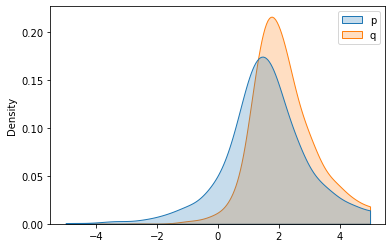

In [14]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 5), fill=True)

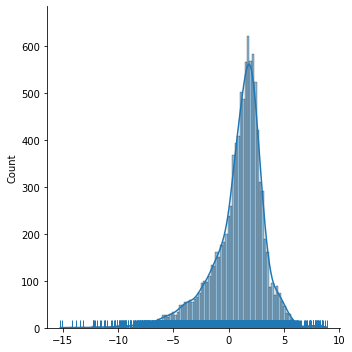

In [13]:
sns.displot(x=p_energys, kde=True, rug=True)

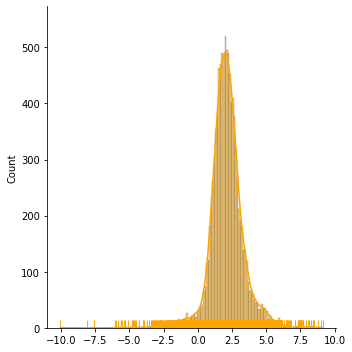

In [14]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

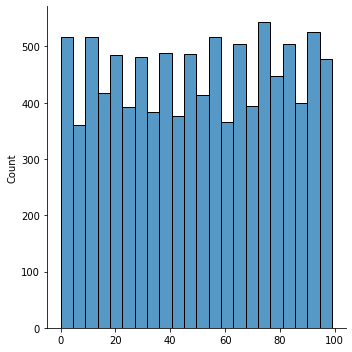

In [15]:
sns.displot(x=p_predict)

## Unconditional energy distribution
Considering the distribution of unconditional generation $p_{\theta}(x)$.

In [16]:
model.eval()
p_energys = []
q_energys = []
for idx, data in tqdm.tqdm(enumerate(test_p_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x)[0].mean()
    p_energys.append(f.item())
    
print('Positive Samples:')
print('Max: {:.4f}'.format(max(p_energys)))
print('Min: {:.4f}'.format(min(p_energys)))
print('Mean: {:.4f}'.format(sum(p_energys) / len(p_energys)))

for idx, data in tqdm.tqdm(enumerate(test_n_loader)):
    x, y, i = data
    x = x.to(device)
    y = y.to(device)
    
    f = model(x=x)[0].mean()
    q_energys.append(f.item())
    


print('Negative Samples:')
print('Max: {:.4f}'.format(max(q_energys)))
print('Min: {:.4f}'.format(min(q_energys)))
print('Mean: {:.4f}'.format(sum(q_energys) / len(q_energys)))

10000it [01:18, 127.25it/s]

Positive Samples:
Max: 8.8759
Min: -10.3981
Mean: 2.0606



10000it [01:18, 127.34it/s]

Negative Samples:
Max: 9.1379
Min: -8.6306
Mean: 2.3224


In [17]:
np.save(os.path.join(opt.save_folder, 'px_energy.npy'), np.asarray(p_energys))
np.save(os.path.join(opt.save_folder, 'qx_energy.npy'), np.asarray(q_energys))

<AxesSubplot:ylabel='Density'>

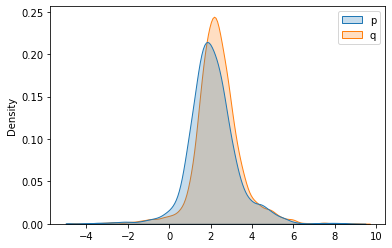

In [18]:
sns.kdeplot(data={'p':p_energys, 'q':q_energys}, clip=(-5, 10), fill=True)

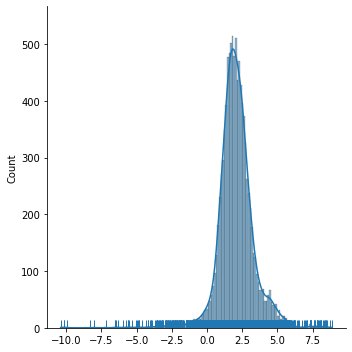

In [19]:
sns.displot(x=p_energys, kde=True, rug=True)

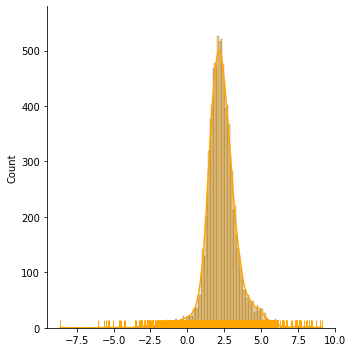

In [20]:
sns.displot(x=q_energys, color='orange', rug=True, kde=True)

In [21]:
f = open(os.path.join(opt.save_folder, 'best.txt'), 'w')
f.write('best_result:{:.4f} +- {:.4f}'.format(mean, var))
f.close()